# Estimate production rate

This notebooks fits analytical reaction-diffusion model to fitted concentration profiles to estimate the production rate of HQNO and RHL by PA. It assumes a constant rate of production. 

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sympy as sp
import sys
sys.path.append(str(Path.cwd().parent / '0_plot_functions'))
from plot_publication_figures import plot_dual_axis_percentiles 

# Analytic S from cmax at x = L + d
# S = (2D/L^2) * cmax * [ 1 + (k / tanh(kL)) * ( L + (W/Wgap)*d ) ]
# where k = sqrt(uptake / D)
def S_from_cmax(cmax, L, d, W, Wgap, D, uptake):
    '''Calculate uptake from maximum concentration and other parameters.
    Parameters:
    -----------
    cmax : float
        Maximum concentration in the chamber (in µg/ml (RHL) or ng/ml (HQNO))
    L : float
        Length of the chamber (in µm)
    d : float
        length of connectors between chambers (in µm)
    W : float
        Width of the chamber (in µm)
    Wgap : float
        Width of the connectors between chambers (in µm)
    D : float
        Diffusion coefficient of the molecule (in µm^2/s)
    uptake : float
        Uptake rate (in 1/s)

    Returns:
        --------
    float
        Calculated production rate (in µg/(ml·s) for RHL or ng/(ml·s) for HQNO)
    '''
    k = np.sqrt(uptake/D)
    z = k*L
    return (2*D/L**2) * cmax * (1.0 + (k/np.tanh(z)) * (L + (W/Wgap)*d))


def plot_fit_summary(df_fit_results, cols_to_plot, fig_size=(6, 3), nrow=1, axlims_dict=None, axlabel_dict=None):
    """
    Plot summary of fit results with stripplot and pointplot.

    Parameters:
    -----------
    df_fit_results : pd.DataFrame
        Dataframe with fit results per chamber
    cols_to_plot : list of str
        List of column names to plot
    fig_size : tuple, optional
        Figure size in inches (default: (6, 3))
    nrow : int, optional
        Number of rows in the subplot grid (default: 1)
    axlims_dict : dict, optional
        Dictionary with axis limits per column, and number of ticks, e.g., {'c_max': (0, 500, 6)}
    axlabel_dict : dict, optional
        Dictionary with x-axis labels per column for 'combined' mode

    Returns:
    --------
    axs : np.ndarray
        Array of axes objects
    """

    ncol =  int(np.ceil(len(cols_to_plot) / nrow))

    fig,axs = plt.subplots(nrow,ncol,figsize=fig_size)
    font_size = 8

    def calc_iqr(x):
        q1 = np.percentile(x, 25)
        q3 = np.percentile(x, 75)
        return (q1, q3)

    for ax, col in zip(axs.flatten(), cols_to_plot):

        sns.stripplot(
            data=df_fit_results,
            x='molecule',
            y=col,
            hue='replicate',
            size=4,
            palette='pastel',
            alpha=0.75,
            ax=ax,
            zorder=1
        )

        # Build base arguments
        plot_kwargs = {
            'data': df_fit_results,
            'y': col,
            'estimator': 'median',
            'errorbar': calc_iqr,
            'color': 'black',
            'markers': '_',
            'markersize': 20,
            'markeredgewidth': 3,
            'linewidth': 2,
            'linestyle': 'none',
            'ax': ax,
            'zorder': 2
        }
        
        plot_kwargs['x'] = 'molecule'
        #plot_kwargs['hue'] = 'replicate'
        #plot_kwargs['palette'] = 'dark'
    
        sns.pointplot(**plot_kwargs)
    
        if axlims_dict and col in axlims_dict:
            ax.set_ylim(axlims_dict[col][0:2])
            ax.set_yticks(np.linspace(axlims_dict[col][0], axlims_dict[col][1], axlims_dict[col][2]))
            n_clipped = df_fit_results[col] > axlims_dict[col][1]
            if n_clipped.any():
                print(f"Warning: {n_clipped.sum()} values clipped in column '{col}'")



        ax.tick_params(labelsize=font_size-1)
        ax.tick_params(labelsize=font_size-1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, alpha=0.3)

        ax.set_ylabel(axlabel_dict.get(col, '') if axlabel_dict else col, fontsize=font_size)
        ax.set_xlabel('' , fontsize=font_size)

        # turn legend off for this axis
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()


    num_panels = nrow * ncol
    if len(cols_to_plot) < num_panels:
        for i in range(len(cols_to_plot), num_panels):
            axs.flatten()[i].set_visible(False)

    plt.tight_layout()

    return axs



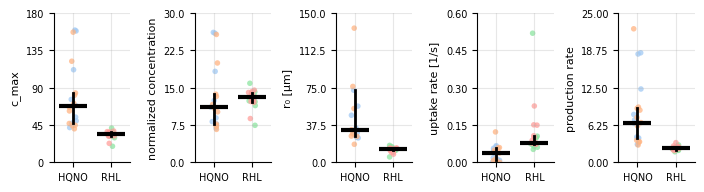

Statistics for c_max:
   HQNO: Median: 67.69, 25-75%: (47.19 - 83.62) ng/ml
   RHL: Median: 33.93, 25-75%: (31.63 - 36.32) µg/ml
Statistics for scaled_conc:
   HQNO: Median: 11.08, 25-75%: (7.726 - 13.69) 
   RHL: Median: 13.06, 25-75%: (12.17 - 13.98) 
Statistics for r0:
   HQNO: Median: 32.76, 25-75%: (26.66 - 72.45) µm, Number clipped in Fig: 3
   RHL: Median: 13.77, 25-75%: (11.95 - 14.31) µm
Statistics for uptake rate:
   HQNO: Median: 0.03728, 25-75%: (0.00762 - 0.05628) 1/s
   RHL: Median: 0.07912, 25-75%: (0.0732 - 0.105) 1/s
Statistics for production rate:
   HQNO: Median: 6.652, 25-75%: (4.033 - 9.038) ng/(ml·s)
   RHL: Median: 2.321, 25-75%: (2.084 - 2.612) µg/(ml·s)


In [2]:

#load data
df_h = pd.read_csv(Path.cwd().parent / '2_gradient_inference' / 'data' / '2_hqno_diffusion_model_fits.csv')
df_r = pd.read_csv(Path.cwd().parent / '2_gradient_inference' / 'data' / '2_rhl_diffusion_model_fits.csv')

# fixed parameters
L = 50.0         # µm, chamber length
d = 3.0          # µm, gap length
W = 50.0         # µm, chamber width
W_gap = 12.5     # µm, gap width (0.25 * W)
D_H = 40.0       # µm²/s - Median diffusion coefficient HQNO
D_R = 15.0       # µm²/s - Median diffusion coefficient RHL

# Load parameters of fitted survival models
with open(Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters.json', "r", encoding="utf-8") as f:
    cfg = json.load(f)

# use parameters of the 'hqno_max_60' model as this fits the empirical concentration ranges best
model_params = cfg['hqno_max_60']['parameters']


# estimate production rate HQNO
uptake_H = df_h["A"] * D_H # A = uptake/D [1/um^2]
prod_H = S_from_cmax(df_h["c_max"].to_numpy(), L, d, W, W_gap, D_H, uptake_H)
df_h["uptake rate"] = uptake_H
df_h["production rate"] = prod_H
df_h["molecule"] = 'HQNO'
df_h['scaled_conc'] = model_params['m_hqno'] * df_h['c_max']


# estimate production rate RHL
uptake_R = df_r["A"] * D_R # A = uptake/D [1/um^2]
prod_R = S_from_cmax(df_r["c_max"].to_numpy(), L, d, W, W_gap, D_R, uptake_R)
df_r["uptake rate"] = uptake_R
df_r["production rate"] = prod_R
df_r["molecule"] = 'RHL'
df_r['scaled_conc'] = np.abs(model_params['m_rhl']) * df_r['c_max']

df_h = df_h[['molecule'] + [c for c in df_h.columns if c != 'molecule']]
df_r = df_r[['molecule'] + [c for c in df_r.columns if c != 'molecule']]

df_combined = pd.concat([df_h, df_r], ignore_index=True)
df_combined = df_combined[['molecule'] + [c for c in df_combined.columns if c != 'molecule']]
df_combined.to_csv(Path.cwd() / 'data' / '3_estimated_production_rates.csv', index=False)

# --- Plot fit results summary ---
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

axlabel_dict = {
    'c_max': 'c_max',
    'scaled_conc': 'normalized concentration',
    'uptake rate': 'uptake rate [1/s]',
    'r0': 'r₀ [µm]',
    'production rate': 'production rate'
}

axlims_dict = {
    'c_max': (0, 180, 5),
    'scaled_conc': (0, 30, 5),
    'uptake rate': (0, 0.6,5),
    'production rate': (0, 25,5),
    'r0': (0, 150,5)
}

cols = ['c_max','scaled_conc', 'r0', 'uptake rate', 'production rate']
axs = plot_fit_summary(df_combined, cols, fig_size=(18/2.54, 5/2.54), nrow=1, axlims_dict=axlims_dict, axlabel_dict=axlabel_dict)
plt.savefig(Path.cwd() / 'figures' / '2_hqno_diffusion_model_fit.pdf', dpi=300, transparent=True)
plt.tight_layout()

plt.savefig(f'./figures/3_production_rate_estimate.pdf', dpi=300, transparent=True)
plt.show()

units = {
    'c_max': {'RHL':'µg/ml', 'HQNO':'ng/ml'},
    'scaled_conc': {'RHL':'', 'HQNO':''},
    'uptake rate': {'RHL':'1/s', 'HQNO':'1/s'},
    'r0': {'RHL':'µm', 'HQNO':'µm'},
    'production rate': {'RHL':'µg/(ml·s)', 'HQNO':'ng/(ml·s)'}
}

# --- Print statistics ---
molecules = ['HQNO', 'RHL']
for col in cols:
    print(f"Statistics for {col}:")
    for mol in molecules:
        subset = df_combined[df_combined['molecule'] == mol]
        stats = subset[col].quantile([0.25, 0.5, 0.75]).to_numpy()
        nclippped = subset[col] > axlims_dict.get(col, (np.inf, np.inf))[1]
        if nclippped.sum() > 0:
            print(f"   {mol}: Median: {stats[1]:.4g}, 25-75%: ({stats[0]:.4g} - {stats[2]:.4g}) {units[col][mol]}, Number clipped in Fig: {nclippped.sum()}")
        else:
            print(f"   {mol}: Median: {stats[1]:.4g}, 25-75%: ({stats[0]:.4g} - {stats[2]:.4g}) {units[col][mol]}")



## Plot concentration profiles including producer region
   
Solve the reaction-diffusion system symbolically for a 3-region domain.

The domain consists of:
- Producer region [0, L]: source term S, solution form R_I = -S/(2D)*x^2 + A*x
- Gap region [L, L+d]: passive diffusion, solution form R_II = C1*x + C2
- Consumer region [L+d, 2L+d]: sink term up, solution form R_III = M*sinh(k*(2L+d-x)), where k = sqrt(up/D)

Boundary conditions:
- R(0) = 0 (Dirichlet at left boundary)
- R(2L+d) = 0 (Dirichlet at right boundary)
- Continuity of concentration at interfaces (x=L and x=L+d)
- Width-weighted flux continuity at interfaces

In [24]:
# ----------------------------------------------------------
# Helper to solve a single species on the 3-region domain
# Producer [0, L] with source S; Gap [L, L+d] passive; Consumer [L+d, 2L+d] sink C
# Width-weighted flux continuity at interfaces is enforced.
# Returns numeric R(x), dR/dx(x), flux(x) and fitted constants.
# ----------------------------------------------------------
def solve_symbolic_reaction_diffusion():
    """
    Solve the reaction-diffusion system symbolically for a 3-region domain.
    
    Returns a dictionary containing the symbolic solution for the four integration
    constants (A, C1, C2, M) in terms of the system parameters (L, d, D, S, C, W, W_gap).
    
    The domain consists of:
    - Producer region [0, L]: source term S, solution form R_I = -S/(2D)*x^2 + A*x
    - Gap region [L, L+d]: passive diffusion, solution form R_II = C1*x + C2
    - Consumer region [L+d, 2L+d]: sink term up, solution form R_III = M*sinh(k*(2L+d-x)), where k = sqrt(up/D)
    
    Boundary conditions:
    - R(0) = 0 (Dirichlet at left boundary)
    - R(2L+d) = 0 (Dirichlet at right boundary)
    - Continuity of concentration at interfaces (x=L and x=L+d)
    - Width-weighted flux continuity at interfaces
    
    Returns:
        dict: Symbolic solution with keys A_sym, C1_sym, C2_sym, M_sym
    """
    # Symbolic setup
    L, d, D, S, up, W, W_gap, x = sp.symbols('L d D S up W W_gap x', positive=True)
    k = sp.sqrt(up / D)

    A_sym, C1_sym, C2_sym, M_sym = sp.symbols('A C1 C2 M')

    # Piecewise solution forms:
    R_I   = -S/(2*D)*x**2 + A_sym*x                         # Producer with source S
    R_II  = C1_sym*x + C2_sym                               # Gap (pure diffusion)
    R_III = M_sym*sp.sinh(k*(2*L + d - x))                  # Consumer with sink C

    # Derivatives
    R_Ip, R_IIp, R_IIIp = sp.diff(R_I, x), sp.diff(R_II, x), sp.diff(R_III, x)

    # BCs + width-weighted flux continuity
    eqs = [
        sp.Eq(R_I.subs(x, 0), 0),                                # R(0) = 0
        sp.Eq(R_III.subs(x, 2*L + d), 0),                        # R(2L+d) = 0
        sp.Eq(R_I.subs(x, L), R_II.subs(x, L)),                  # Continuity at x=L
        sp.Eq(W * R_Ip.subs(x, L), W_gap * R_IIp.subs(x, L)),    # Flux continuity at x=L
        sp.Eq(R_II.subs(x, L + d), R_III.subs(x, L + d)),        # Continuity at x=L+d
        sp.Eq(W_gap * R_IIp.subs(x, L + d), W * R_IIIp.subs(x, L + d)) # Flux continuity at x=L+d
    ]

    return sp.solve(eqs, (A_sym, C1_sym, C2_sym, M_sym), dict=True)[0]

def conc_curve(solution_expr, L_val, d_val, W_val, W_gap_val, D_val, S_val, up_val, x_vals):
    """
    Compute steady-state concentration profile R(x) on a 3-region domain using the
    symbolic solution constants and specified parameter values.

    Args:
        solution_expr (dict): Symbolic expressions for A, C1, C2, M from solve_symbolic_reaction_diffusion.
        L_val (float): Length of producer/consumer regions.
        d_val (float): Length of the gap region.
        W_val (float): Width of producer/consumer regions.
        W_gap_val (float): Width of the gap region.
        D_val (float): Diffusion coefficient.
        S_val (float): Source term in the producer region.
        up_val (float): Uptake (sink) rate in the consumer region.
        x_vals (array-like): Positions at which to evaluate R(x).

    Returns:
        np.ndarray: Concentration values R(x) evaluated at x_vals.
    """
    # set up symbols and substitute parameter values
    A_sym, C1_sym, C2_sym, M_sym = sp.symbols('A C1 C2 M')
    L, d, D, S, up, W, W_gap = sp.symbols('L d D S up W W_gap', positive=True)
    num = {L: L_val, d: d_val, W: W_val, W_gap: W_gap_val, D: D_val, S: S_val, up: up_val}
    A_val  = float(analytical_solution[A_sym].subs(num))
    C1_val = float(analytical_solution[C1_sym].subs(num))
    C2_val = float(analytical_solution[C2_sym].subs(num))
    M_val  = float(analytical_solution[M_sym].subs(num))
    k_val  = float(sp.sqrt(up_val / D_val))

    x_arr = np.asarray(x_vals, dtype=float)
    out = np.empty_like(x_arr)

    # Define masks for the three regions
    m1 = x_arr < L_val
    m2 = (x_arr >= L_val) & (x_arr < L_val + d_val)
    m3 = ~(m1 | m2)

    # Compute concentration in each region
    out[m1] = -S_val/(2 * D_val) * x_arr[m1]**2 + A_val * x_arr[m1]
    out[m2] = C1_val * x_arr[m2] + C2_val
    out[m3] = M_val * np.sinh(k_val * (2 * L_val + d_val - x_arr[m3]))
    return out


# --- Predict concentration profiles---
y_fit = np.linspace(0, 2*L + d, 181)
y_from_center = y_fit - (L + d/2)

# Solve symbolic reaction-diffusion system
analytical_solution = solve_symbolic_reaction_diffusion()

# Calculate concentration profiles using exhaustive empirical sampling of replicates to estimate variability
pred_conc_H = []
for i in range(len(df_h.index)):
    S_H = df_h["production rate"].iloc[i]
    up_H = df_h["uptake rate"].iloc[i]
    conc_H = conc_curve(analytical_solution, L, d, W, W_gap, D_H, S_H, up_H, y_fit)
    pred_conc_H.append({'replicate': i, 'y_um': y_from_center, 'concentration': conc_H})

pred_conc_R = []
for i in range(len(df_r.index)):
    S_R = df_r["production rate"].iloc[i]
    up_R = df_r["uptake rate"].iloc[i]
    conc_R = conc_curve(analytical_solution, L, d, W, W_gap, D_R, S_R, up_R, y_fit)
    pred_conc_R.append({'replicate': i, 'y_um': y_from_center, 'concentration': conc_R})

df_pred_conc_H = pd.DataFrame(pred_conc_H).explode(['y_um', 'concentration'])
df_pred_conc_R = pd.DataFrame(pred_conc_R).explode(['y_um', 'concentration'])


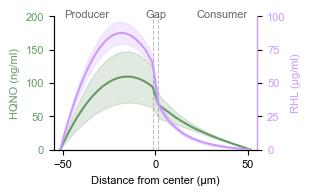

[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands


In [25]:
# ——— figure style ———
final_width_cm = 8    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
font_size = 8  # points
plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Arial',
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'legend.fontsize': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# HQNO color (green)
hqno_color = '#669966'

# RHL color (purple)
rhl_color = '#cc99ff'

# --- Plot measured concentration gradients ---
left_data = [{
    'df': df_pred_conc_H,
    'y_col': 'concentration',
    'label': 'HQNO',
    'color': hqno_color,
    'ylabel': 'HQNO (ng/ml)',
    'ylim': (0, 200),
    'yticks': np.linspace(0, 200, 5)
}]

right_data = [{
    'df': df_pred_conc_R,
    'y_col': 'concentration',
    'label': 'RHL',
    'color': rhl_color,
    'ylabel': 'RHL (µg/ml)',
    'ylim': (0,  100),
    'yticks': np.linspace(0, 100, 5)
}]

x_config = {
    'xlabel': "Distance from center (µm)",
    'xlim': (-55, 55),
    'xticks': [-50,0,50]
}

fig, ax = plot_dual_axis_percentiles(
    left_axis_data=left_data,
    right_axis_data=right_data,
    x_col='y_um',
    x_config=x_config,
    percentiles=[25, 50, 75],
    figsize=(final_width_in, final_height_in),
    font_size=font_size
)
ax.axvline(x=-d/2, linestyle='--', color='gray', linewidth=0.75, alpha=0.5)
ax.axvline(x=d/2, linestyle='--', color='gray', linewidth=0.75, alpha=0.5)

# Add region labels using axis coordinates (0-1 range) instead of data coordinates
ax.text(0.05, 1.05, 'Producer', transform=ax.transAxes,
         ha='left', va='top', fontsize=font_size, alpha=0.6)
ax.text(0.5, 1.05, 'Gap', transform=ax.transAxes,
         ha='center', va='top', fontsize=font_size, alpha=0.6)
ax.text(0.95, 1.05, 'Consumer', transform=ax.transAxes,
         ha='right', va='top', fontsize=font_size, alpha=0.6)

ax.get_legend().remove()

# Save outputs
plt.savefig(f'./figures/3_concentration_profiles_with_producers.pdf', dpi=300, transparent=True)
plt.show()

print(f"[info] Plotted HQNO (left axis) and RHL (right axis) with percentile bands")
